# Project: Public and Private Grad Rates Analysis (2019 U.S. College Data)
# Author: Robert Zacchigna

# Table of Contents

* [Question and Hypothesis](#Question_and_Hypothesis)
* [Dataset - U.S. College Data (2019)](#Dataset)
    * [Download Location](#Download_Location)
    * [Columns](#Columns)
* [Imports](#Imports)
* [Classes](#Classes)
* [Definitions](#Definitions)


* **[Part 1: Exploratory Data Analysis](#Part_1)**
    * [Load Dataset Using Pandas](#Part_1-Load_Dataset)
    * [Variable Histograms](#Part_1-Var_Hists)
    * [Outliers](#Part_1-Outliers)
    * [Summary Statistics](#Part_1-Summ_Stats)
    * [Split Dataset](#Part_1-Split_Dataset)
    * [PMF - Public and Prives Uni's Percent of Faculty with PhD's](#Part_1-PMF)
    * [CDF - Public and Prives Uni's Graduation Rates (Percent)](#Part_1-CDF)
    * [Analytical Distribution - Normal Probability Plots](#Part_1-Analytic_Dist)
    * [Scatter Plots - Public and Private Acceptance vs. New Enrollment](#Part_1-Scatter_Plot)
    * [Hypothesis Tests](#Part_1-Hype_Test)


* **[Part 2: Regression Analysis](#Part_2)**
    * [Least Squares Fit](#Part_2-Least_Squares)
        * [Best Fit Plot](#Part_2-Best_Fit)
        * [Residuals](#Part_2-Residuals)
        * [Showing Uncertainty](#Part_2-Showing_Uncertainty)
        * [Coefficient of Determination](#Part_2-Coe_Det)
        * [Slope Hypothesis Test](#Part_2-Slope_Hype)
    * [Multiple Regression](#Part_2-Multi_Regr)
        * [All Variables](#Part_2-All_Vars)
        * [Only Statistically Significant Variables](#Part_2-Stat_Vars)


* **[Conclusion](#Conclusion)**

<a id='Question_and_Hypothesis'></a>
## Question and Hypothesis:

__Question:__ Does a University being Private or Public have an effect on its graduation rate and what factors specifically affect those rates?

__Hypothesis:__ Private universities might have a higher graduation rate than public universities and that the biggest factors for the graduation rate will be: the number of students enrolled, the amount of faculty with PhD’s and economic factors of the university (Variables: Room.Board, Books, Personal and Expend).

<a id='Dataset'></a>
## Dataset - U.S. College Data (2019)

<ins>Download Location:</ins> https://www.kaggle.com/yashgpt/us-college-data <a id='Download_Location'></a>

<ins>Columns:</ins><a id='Columns'></a>
* __Private__ – Categorical variable of Yes and No indicating private or public university (Yes = Private, No = Public)
* __Apps__ – Number of applications received
* __Accept__ – Number of applications accepted
* __Enroll__ – Number of new students enrolled
* __Top10perc__ - Percentage of new students from top 10% of H.S. class
* __Top25perc__ - Percentage of new students from top 25% of H.S. class
* __F.Undergrad__ - Number of fulltime undergraduates
* __P.Undergrad__ - Number of parttime undergraduates
* __Outstate__ - Out-of-state tuition
* __Room.Board__ – Room and Board costs (U.S. Dollars)
* __Books__ – Estimated Book costs (U.S. Dollars)
* __Personal__ – Estimated personal spending (U.S. Dollars)
* __PhD__ – Percentage of faculty with Ph.D.’s
* __Terminal__ - Percentage of faculty with terminal degree
* __S.F.Ratio__ - Student/Faculty Ratio
* __perc.alumni__ - Percentage alumni who donate
* __Expend__ – Instructional expenditure per student (U.S. Dollars)
* __Grad.Rate__ – Graduation rate (Percentage)

<a id='Imports'></a>
## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.formula.api as smf

from scipy.stats import norm
from ThinkStats2 import thinkplot
from ThinkStats2 import thinkstats2
from matplotlib import pyplot as plt
from ThinkStats2.thinkstats2 import Mean, MeanVar, Var, Std, Cov

<a id='Classes'></a>
## Classes

In [2]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        
        return data

In [3]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        
        return test_stat

In [4]:
class ChiSquares(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        
        return data

    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        
        stat = sum((observed - expected) ** 2 / expected)
        
        return stat

In [5]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

<a id='Definitions'></a>
## Definitions

In [6]:
def FalseNegRate(data, num_runs=1000):
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [7]:
def createHist(data, varList: list, histLabels: list):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.8, wspace=0.5)
    fig.set_size_inches(13.5, 10)

    i = 1
    for var in varList:
        fig.add_subplot(3, 3, i)
        sb.distplot(pd.Series(data[var], name=histLabels[i-1]), fit=norm, kde=False).set_title(var + " Histogram")
        i += 1

    fig.tight_layout()
    plt.show()

In [8]:
def getPubPrivCount(data):
    yesCounter = 0
    noCounter = 0

    for i in range(len(data["Private"])):
        if data["Private"][i] == "Yes":
            yesCounter += 1
        else:
            noCounter += 1

    return yesCounter, noCounter

In [9]:
def getSummaryStats(data, varList: list, tails: list):
    i = 0

    for col in varList:
        print('Variable: ' + col + '\n===========================\n     Tail: ' + tails[i] +
              '\n     Mean: {:>16,.5f}\n Variance\n (Spread): {:>16,.5f}'
               '\nStandard\nDeviation: {:>16,.5f}\n  Mode(s): '
              .format(data[col].mean(), data[col].var(), data[col].std()))

        print('' + str(data[col].mode()) + '\n')

        i += 1

In [10]:
def PearsonCorr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = thinkstats2.Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    
    return corr

In [11]:
def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    
    return PearsonCorr(xranks, yranks)

In [12]:
def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [13]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    
    return fit_xs, fit_ys

In [14]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    res = ys - (inter + slope * xs)
    
    return res

In [15]:
def PlotPercentiles(means, cdfs):
    thinkplot.PrePlot(3)
    
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(means, weight_percentiles, label=label)

In [16]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

In [17]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    
    return sample

In [18]:
def ResampleRows(df):
    return SampleRows(df, len(df), replace=True)

In [19]:
def SamplingDistributions(data, iters=101):
    data = data.rename(columns = {'Grad.Rate': 'Grad_Rate'})
    t = []
    
    for _ in range(iters):
        sample = ResampleRows(data)
        gradRate = sample.Grad_Rate
        enroll = sample.Enroll
        estimates = LeastSquares(gradRate, enroll)
        t.append(estimates)

    inters, slopes = zip(*t)
    
    return inters, slopes

In [20]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

<a id='Part_1'></a>
# Part 1: Exploratory Data Analysis
<a id='Part_1-Load_Dataset'></a>
## Load Dataset Using Pandas

In [21]:
collegeData = pd.read_csv('College_Data.csv')

print("This dataset has: {:,} columns and {:,} rows".format(collegeData.shape[1], collegeData.shape[0]))
collegeData.head()

This dataset has: 19 columns and 777 rows


,Uni.Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


<a id='Part_1-Var_Hists'></a>
## Variable Histograms

In [5]:
priv, pub = getPubPrivCount(collegeData)

print("Since the \"Private\" variable is a categorical variable (not a number), I counted the number of "
      "universities in this dataset that are Private and Public:\n\nPrivate: {}\n Public: {}\n============\n"
      "  Total: {}"
      .format(priv, pub, priv + pub))

Since the "Private" variable is a categorical variable (not a number), I counted the number of universities in this dataset that are Private and Public:

Private: 565
 Public: 212
  Total: 777


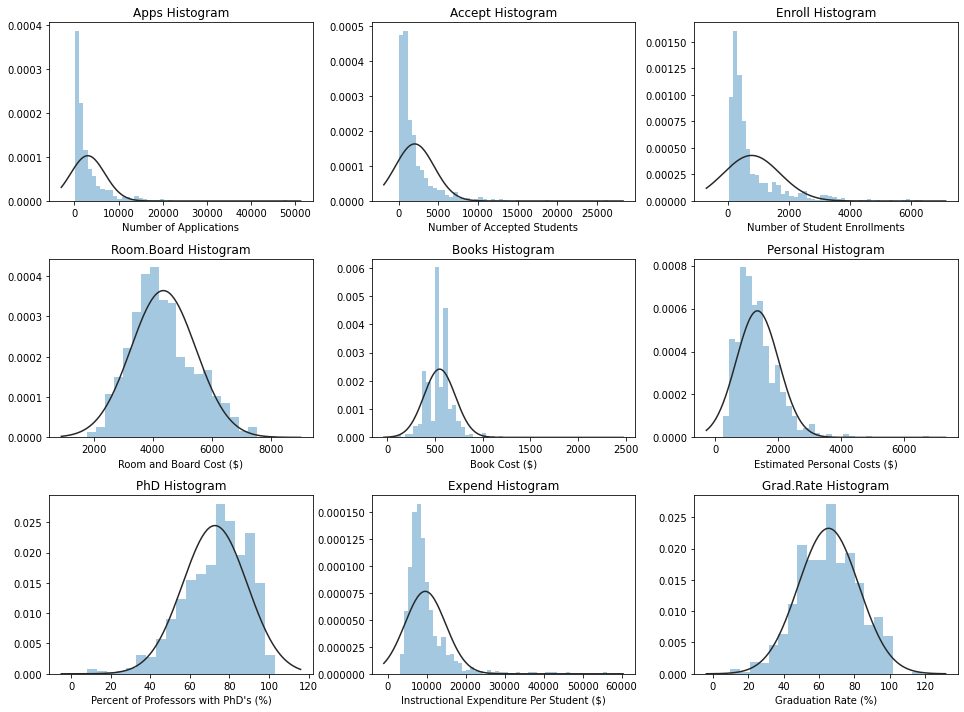

In [4]:
varList = ["Apps", "Accept", "Enroll", "Room.Board", "Books", "Personal", "PhD", "Expend", "Grad.Rate"]

histLabels = ["Number of Applications", "Number of Accepted Students", "Number of Student Enrollments",
              "Room and Board Cost ($)", "Book Cost ($)", "Estimated Personal Costs ($)",
              "Percent of Professors with PhD's (%)", "Instructional Expenditure Per Student ($)",
              "Graduation Rate (%)"]

createHist(collegeData, varList, histLabels)

<a id='Part_1-Outliers'></a>
## Outliers

This finds the top 10 smallest and largest values for each of the variables in this dataset to help identify any outliers that might need some attention.

In [7]:
for col in varList:
    print('Top 10 Smallest values from: ' + col + '\n' + str(collegeData[col].nsmallest(10)) +
          '\n\nTop 10 Largest values from: ' + col + '\n' + str(collegeData[col].nlargest(10)) + '\n\n')

Top 10 Smallest values from: Apps
110     81
85     100
135    141
500    150
768    152
764    167
105    174
548    191
4      193
51     202
Name: Apps, dtype: int64

Top 10 Largest values from: Apps
483    48094
461    21804
59     20192
605    19873
445    19315
637    19152
366    18114
274    16587
693    15849
713    15712
Name: Apps, dtype: int64


Top 10 Smallest values from: Accept
110     72
85      90
135    118
768    128
500    130
764    130
731    143
4      146
105    146
539    155
Name: Accept, dtype: int64

Top 10 Largest values from: Accept
483    26330
461    18744
366    15096
274    13243
59     13007
637    12940
634    12414
713    11719
623    11652
700    10932
Name: Accept, dtype: int64


Top 10 Smallest values from: Enroll
85     35
764    46
110    51
4      55
135    55
548    63
539    75
768    75
731    79
311    82
Name: Enroll, dtype: int64

Top 10 Largest values from: Enroll
581    6392
366    6180
461    5874
274    5873
623    5705
685    5329
6

I will save you the trouble of looking through the output but there are two variables that have outliers that need some attention: PhD and Grad.Rate

In [8]:
print('University Name: ' + str(collegeData['Uni.Name'][582]) +
      '\nPercentage of Faculty with PhD\'s: ' + str(collegeData['PhD'][582]) +
      '%\n\nUniversity Name: ' + str(collegeData['Uni.Name'][95]) +
      '\nGraduation Rate: ' + str(collegeData['Grad.Rate'][95]) + '%')

University Name: Texas A&M University at Galveston
Percentage of Faculty with PhD's: 103%

University Name: Cazenovia College
Graduation Rate: 118%


Texas A&M University at Galveston lists a faculty PhD percentage of 103% which, in the context of the variable measured, is impossible because the variable is measuring the number of faculty with *at least* one PhD and thus if a person has multiple PhD’s they will only be counted as one.

Cazenovia College lists a graduation rate of 118% which is also impossible because you can't have more students graduated than the number of students in the graduating class.

For the above reasons, these two data points will be removed from the dataset as they are more than likely a data collection error.

In [23]:
# 582 is the index of Texas A&M University at Galveston in the dataset
# 95 is the index of Cazenovia College in the dataset

collegeData = collegeData.drop(index=[95, 582])

<a id='Part_1-Summ_Stats'></a>
## Summary Statistics

In [10]:
# Taken from the variable histograms above
tails = ['Right', 'Right', 'Right', 'None', 'None', 'Right', 'Left', 'Right', 'None']

getSummaryStats(collegeData, varList, tails)

Variable: Apps
     Tail: Right
     Mean:      3,003.73806
 Variance
 (Spread): 15,008,336.69487
Standard
Deviation:      3,874.05946
  Mode(s): 
0     440
1     663
2    1006
dtype: int64

Variable: Accept
     Tail: Right
     Mean:      2,018.96387
 Variance
 (Spread):  6,017,844.85141
Standard
Deviation:      2,453.12960
  Mode(s): 
0    452
dtype: int64

Variable: Enroll
     Tail: Right
     Mean:        780.99226
 Variance
 (Spread):    865,143.06454
Standard
Deviation:        930.13067
  Mode(s): 
0    177
1    295
dtype: int64

Variable: Room.Board
     Tail: None
     Mean:      4,358.49806
 Variance
 (Spread):  1,203,576.94024
Standard
Deviation:      1,097.07654
  Mode(s): 
0    4100
dtype: int64

Variable: Books
     Tail: None
     Mean:        549.25032
 Variance
 (Spread):     27,323.58067
Standard
Deviation:        165.29846
  Mode(s): 
0    500
dtype: int64

Variable: Personal
     Tail: Right
     Mean:      1,342.61806
 Variance
 (Spread):    458,077.12267
Standard

<a id='Part_1-Split_Dataset'></a>
## Split Dataset

For the purposes of this analysis, i am comparing the graduation rates of Public and Private universities to see which one is higher and to see which variables have the greatest significance in determining that grad rate. As a result, I will be splitting the dataset into two parts: Public and Private universities.

In [24]:
# Split dataset into two parts: Public and Private universities
publicUni = collegeData[collegeData['Private'] == 'No']
privateUni = collegeData[collegeData['Private'] == 'Yes']

<a id='Part_1-PMF'></a>
## PMF - Public and Private Uni's Percent of Faculty with PhD's

I decided to take a look and see if public or private universities have a higher percentage of faculty with PhD's.

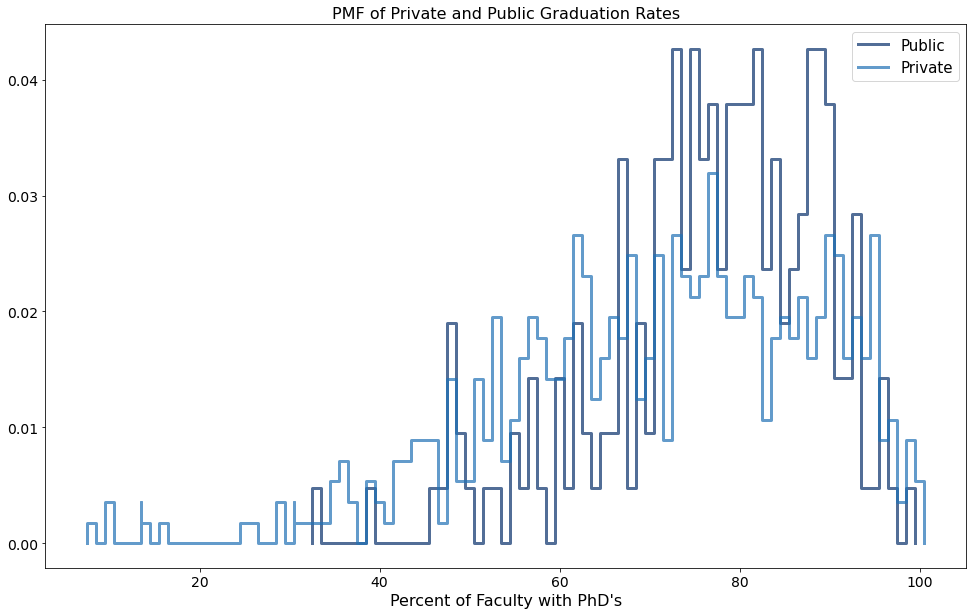

In [10]:
# Create the PMF's of PhD's
publicPhD = thinkstats2.Pmf(publicUni['PhD'], label='Public')
privatePhD = thinkstats2.Pmf(privateUni['PhD'], label='Private')

# Plot the PMF's
fig = plt.figure()
plt.rcParams['axes.titlesize'] = 16
fig.set_size_inches(16.5, 10)
thinkplot.set_font_size(5)

thinkplot.Pmfs([publicPhD, privatePhD])
thinkplot.Config(title='PMF of Private and Public Graduation Rates', xlabel='Percent of Faculty with PhD\'s')
plt.legend(prop={"size":15})

Judging from the graph above, it would appear that public universities have a higher percentage of faculty with PhD's compared to private universities.

<a id='Part_1-CDF'></a>
## CDF - Public and Private Graduation Rates (Percent)

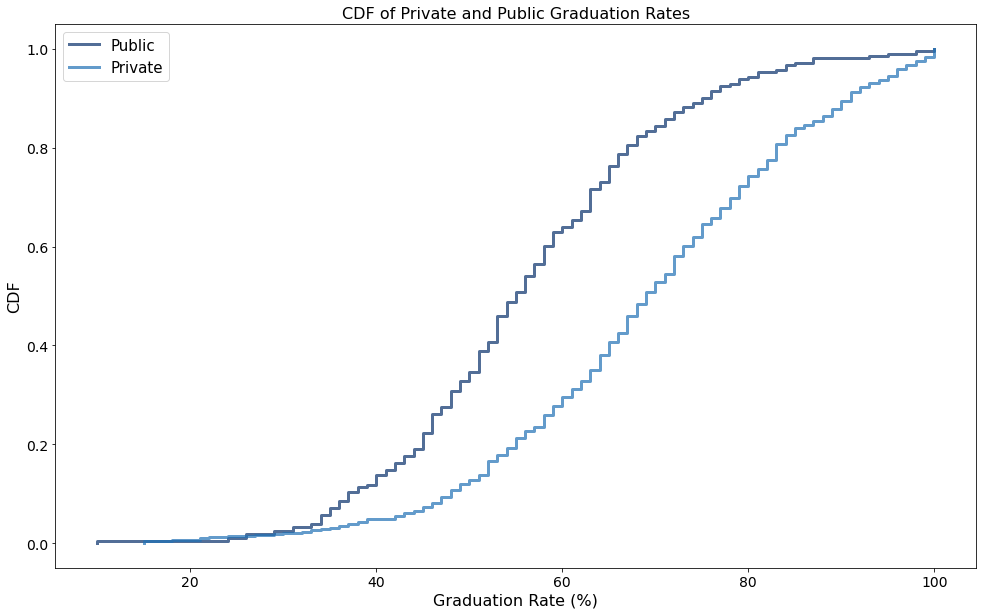

In [24]:
public_cdf = thinkstats2.Cdf(publicUni['Grad.Rate'], label='Public')
private_cdf = thinkstats2.Cdf(privateUni['Grad.Rate'], label='Private')

fig = plt.figure()
fig.set_size_inches(16.5, 10)
plt.rcParams['axes.titlesize'] = 16

thinkplot.set_font_size(5)
thinkplot.Cdfs([public_cdf, private_cdf])
thinkplot.Config(title='CDF of Private and Public Graduation Rates', xlabel='Graduation Rate (%)', ylabel='CDF')
plt.legend(prop={"size":15})

From the above graph we can see that public universities consistently have a higher graduation rate than private ones. This tells me that my initial hypothesis that private universities would have a higher graduation rate is not correct. 

I will need to investigate more to find which variables are significantly contributing the difference in grad rate between public and private universities.

<a id='Part_1-Analytic_Dist'></a>
## Analytical Distribution - Normal Probablity Plots

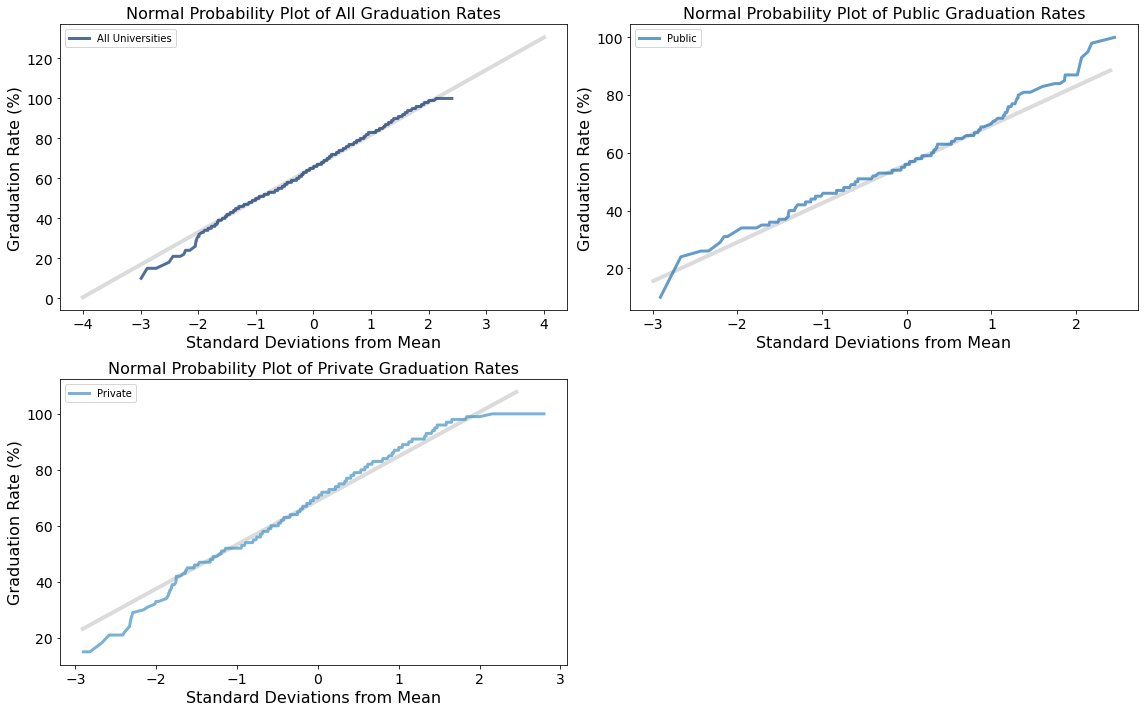

In [99]:
fig = plt.figure()
fig.set_size_inches(16, 10)
fig.subplots_adjust(hspace=0.8, wspace=0.5)

plt.rcParams['axes.titlesize'] = 16
labels = ['All', 'Public', 'Private']
xs = [-4, 4]

for i in range(1, 4):
    fig.add_subplot(2, 2, i)
    thinkplot.set_font_size(5)

    if i == 1:
        mean, var = thinkstats2.TrimmedMeanVar(collegeData[varList[8]], p=0.01)
        std = np.sqrt(var)
    elif i == 2:
        mean, var = thinkstats2.TrimmedMeanVar(publicUni[varList[8]], p=0.01)
        std = np.sqrt(var)
    elif i == 3:
        mean, var = thinkstats2.TrimmedMeanVar(privateUni[varList[8]], p=0.01)
        std = np.sqrt(var)

    fxs, fys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

    if i == 1:
        xs, ys = thinkstats2.NormalProbability(collegeData[varList[8]])
        thinkplot.Plot(xs, ys, label= labels[i-1] + ' Universities')
    elif i == 2:
        xs, ys = thinkstats2.NormalProbability(publicUni[varList[8]])
        thinkplot.Plot(xs, ys, label=labels[i-1])
    elif i == 3:
        xs, ys = thinkstats2.NormalProbability(privateUni[varList[8]])
        thinkplot.Plot(xs, ys, label=labels[i-1])

    thinkplot.Config(title='Normal Probability Plot of ' + labels[i-1] + ' Graduation Rates',
                     xlabel='Standard Deviations from Mean',
                     ylabel='Graduation Rate (%)')
    fig.tight_layout()

From the Normal Probability Plots above, we can see that the distribution of **All** university graduation rates is approximately normal with a slight tail on the left side. 

Public and Private graduation rate plots makes it clear that their distributions also follow normality but with more pronounced tails on both ends. 

The graphs also show that the distribution of all the graduation rates (public and private) is approximately normal and that there isn't significant skewness to the data that could disproportionally sway the analysis.

<a id='Part_1-Scatter_Plot'></a>
## Scatter Plots - Public and Private Acceptance vs. New Enrollment

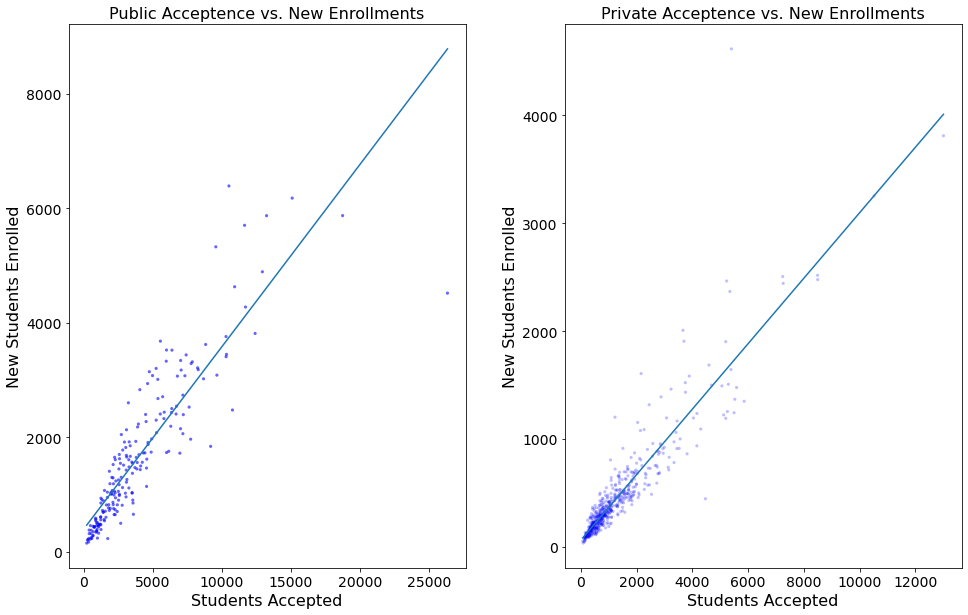

In [83]:
fig = plt.figure()
fig.set_size_inches(16, 10)
fig.subplots_adjust(hspace=0.8, wspace=0.25)

plt.rcParams['axes.titlesize'] = 16
labels = ['Public', 'Private']

for i in range(1, 3):
    fig.add_subplot(1, 2, i)
    thinkplot.set_font_size(5)
    
    if i == 1:
        thinkplot.Scatter(publicUni['Accept'], publicUni['Enroll'], alpha=.60, s=10)
        plt.plot(np.unique(publicUni['Accept']), 
                 np.poly1d(np.polyfit(publicUni['Accept'], publicUni['Enroll'], 1))(np.unique(publicUni['Accept'])))
    elif i == 2:
        thinkplot.Scatter(privateUni['Accept'], privateUni['Enroll'], alpha=.25, s=10)
        plt.plot(np.unique(privateUni['Accept']), 
                 np.poly1d(np.polyfit(privateUni['Accept'], privateUni['Enroll'], 1))(np.unique(privateUni['Accept'])))
        
    thinkplot.Config(title=labels[i-1] + ' Acceptence vs. New Enrollments',
                     xlabel='Students Accepted',
                     ylabel='New Students Enrolled',
                     legend=False)

In [77]:
print('|==============================|\n|\tAccept vs. Enroll      |'
      '\n|==========|=========|=========|\n|\t   | Public  | Private |\n'
      '|----------|---------|---------|\n'
      '|  Pearson | {:.5f} | {:.5f} |\n|----------|---------|---------|\n'
      '| Spearman | {:.5f} | {:.5f} |\n|==========|=========|=========|'
      .format(PearsonCorr(publicUni['Accept'], publicUni['Enroll']),
              PearsonCorr(privateUni['Accept'], privateUni['Enroll']),
              SpearmanCorr(publicUni['Accept'], publicUni['Enroll']),
              SpearmanCorr(privateUni['Accept'], privateUni['Enroll'])))

|==============================|
|	Accept vs. Enroll      |
|==========|=========|=========|
|	   | Public  | Private |
|----------|---------|---------|
|  Pearson | 0.87919 | 0.90649 |
|----------|---------|---------|
| Spearman | 0.93174 | 0.92828 |
|==========|=========|=========|


From the two scatter plots and correlation matrix above (detailing both Pearson and Spearman Corrs), we can see that the number of accepted and enrolled students in both public (Pearson: 0.879) and private (Pearson: 0.906) universities is positively strongly correlated and even more so when using Spearman's correlation (Public: 0.932, Private: 0.928) when compared to Pearson's.

This indicates that the number of students accepted and enrolled is linearly related and that as the number of students accepted into the university increases, then the number of new student enrollments will also increase a proportional amount.

<a id='Part_1-Hype_Test'></a>
## Hypothesis Tests

In [105]:
chiSquare = ChiSquares(gradRates)
chi_Actual = chiSquare.actual

print('Hypothesis Tests - Public and Private Grad Rate\n'
      '\nDifference in Means:\n'
      '\tP-value:  {}'
      '\n\nDifference in Standard Deviations:\n'
      '\tP-value:  {}\n'
      '\nChi-Squares:\n'
      '\tP-value:  {}\n'
      '\t Actual: {:.5f}\n'
      '\t Ts Max: {:.5f}\n'
      '\nFalse Negative Rate: {}'.format(DiffMeansPermute(gradRates).PValue(),
                                         DiffStdPermute(gradRates).PValue(),
                                         chiSquare.PValue(), chi_Actual, 
                                         chiSquare.MaxTestStat(),
                                         FalseNegRate(gradRates)))

Hypothesis Tests - Public and Private Grad Rate

Difference in Means:
	P-value:  0.0

Difference in Standard Deviations:
	P-value:  0.99

Chi-Squares:
	P-value:  0.002
	 Actual: 27.46185
	 Ts Max: 32.67935

False Negative Rate: 0.0


The first hypothesis test conducted is the [Difference in Means](https://www.statisticshowto.com/mean-difference/), which resulted in a p-value of zero (odds are its not exactly zero but very small). Since the p-value is smaller than `0.05`, the null hypothesis can be rejected.

The next test is the [Difference in Standard Deviations](https://www.mathsisfun.com/data/standard-deviation-formulas.html), which resulted in a p-value of `0.99`. Since this p-value way greater than `0.05`, the null hypothesis cannot be rejected. However, since the private dataset (564) has quite a few more values than the public dataset (211), the private standard deviation will be much larger and thus skewing the results.

After that test is the [Chi-Squares](https://www.statisticshowto.com/probability-and-statistics/chi-square/) test, which resulted in a p-value of `0.002` and is much lower than `0.05` (as a result we can reject the null hypothesis).

The final test was to see the [False Negative Rate](https://en.wikipedia.org/wiki/False_positives_and_false_negatives), which resulted in a value of `0.0` (odds are its not exactly zero but very small). Which is a good thing because that means that the power of this test has high statistical significance.

<a id='Part_2'></a>
# Part 2: Regression Analysis

<a id='Part_2-Least_Squares'></a>
## Least Squares Fit

<a id='Part_2-Best_Fit'></a>
### Best Fit Plot

I first started with a Least Squares fit to see what the type of relationship of my variables have, specifically if they are linearly related or not.

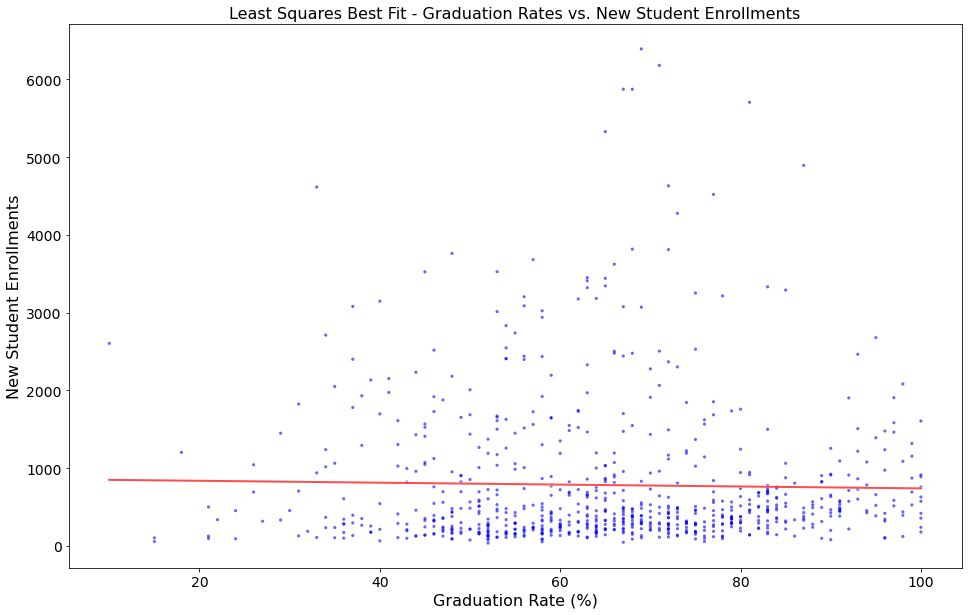

In [25]:
inter, slope = LeastSquares(collegeData['Grad.Rate'], collegeData['Enroll'])

fit_xs, fit_ys = FitLine(collegeData['Grad.Rate'], inter, slope)

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.rcParams['axes.titlesize'] = 16
thinkplot.set_font_size(5)

thinkplot.Scatter(collegeData['Grad.Rate'], collegeData['Enroll'], color='blue', alpha=0.6, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(title='Least Squares Best Fit - Graduation Rates vs. New Student Enrollments', 
                 xlabel="Graduation Rate (%)",
                 ylabel='New Student Enrollments',
                 legend=False)

<a id='Part_2-Residuals'></a>
### Residuals

This is to see if the relationship between Grad.Rate and Enroll is linear by plotting a CDF of the percentiles.

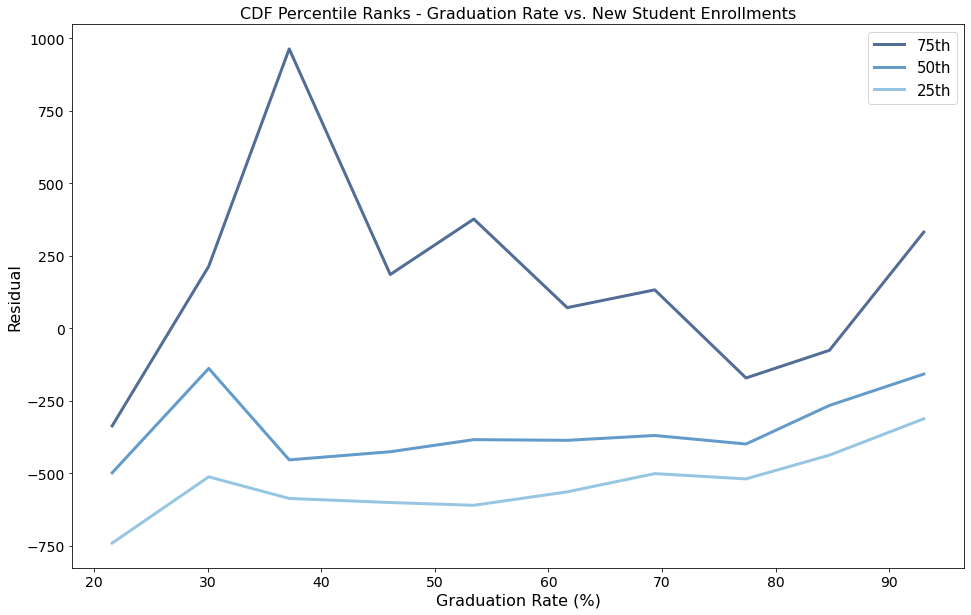

In [27]:
collegeData['residual'] = Residuals(collegeData['Grad.Rate'], collegeData['Enroll'], inter, slope)

collegeData = collegeData.rename(columns = {'Grad.Rate': 'Grad_Rate'})

bins = np.arange(10, 100, 8)
indices = np.digitize(collegeData['Grad_Rate'], bins)
groups = collegeData.groupby(indices)

gradRate_means = [group.Grad_Rate.mean() for _, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.rcParams['axes.titlesize'] = 16

PlotPercentiles(gradRate_means, cdfs)

thinkplot.set_font_size(5)
thinkplot.Config(title='CDF Percentile Ranks - Graduation Rate vs. New Student Enrollments', 
                 xlabel="Graduation Rate (%)",
                 ylabel='Residual', legend=True)
plt.legend(prop={"size":15})

collegeData = collegeData.rename(columns = {'Grad_Rate': 'Grad.Rate'})

The above graph shows the 25th, 50th, and 75th percentiles of the Least Squares residuals.

Since the percentile lines are angled (or otherwise curved) in the residuals, this suggests that there is a non-linear relationship between Graduation Rate and Enrollments.

<a id='Part_2-Showing_Uncertainty'></a>
### Showing Uncertainty

Next, to see the uncertainty of the estimated slope and intercept, a fitted line can be created for each of the resampled estimates and plot them on top of each other.

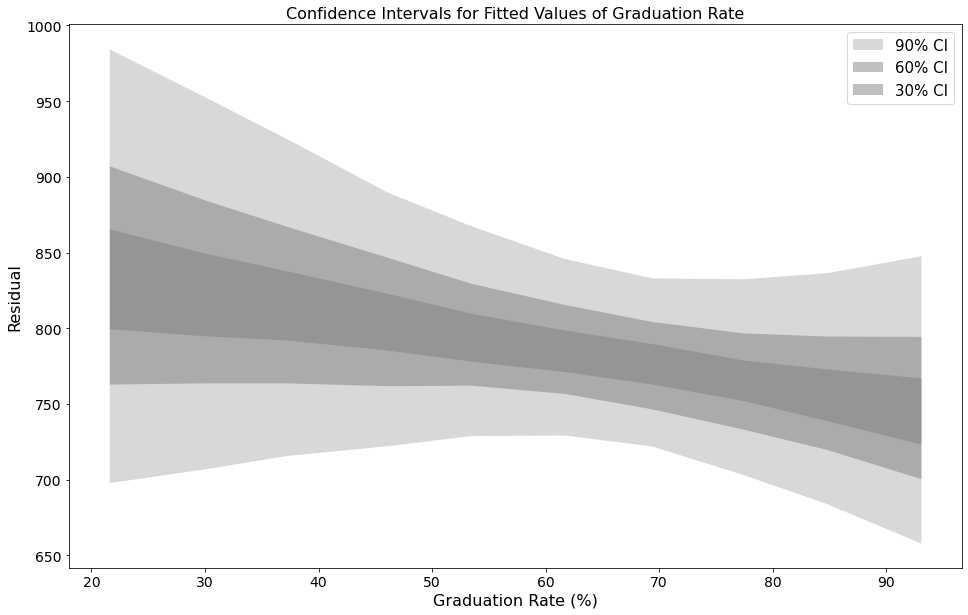

In [100]:
inters, slopes = SamplingDistributions(collegeData, iters=1001)

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.rcParams['axes.titlesize'] = 16

PlotConfidenceIntervals(gradRate_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')

PlotConfidenceIntervals(gradRate_means, inters, slopes, percent=60,
                        color='gray', alpha=0.5, label='60% CI')

PlotConfidenceIntervals(gradRate_means, inters, slopes, percent=30,
                        color='gray', alpha=0.5, label='30% CI')

thinkplot.set_font_size(5)
thinkplot.Config(title='Confidence Intervals for Fitted Values of Graduation Rate', 
                 xlabel="Graduation Rate (%)",ylabel='Residual')

plt.legend(prop={"size":15})

The above graph shows the confidence interval for the fitted values at each Graduation Rate.

<a id='Part_2-Coe_Det'></a>
### Coefficient of Determination

Checking the r squared (r2) value of the variance of the residuals to the variance of my dependent variable (Grad.Rate)

In [29]:
inter, slope = LeastSquares(collegeData['Grad.Rate'], collegeData['Enroll'])

res = Residuals(collegeData['Grad.Rate'], collegeData['Enroll'], inter, slope)
r2 = CoefDetermination(collegeData['Enroll'], res)

print(round(r2, 8))

0.00050201


From the r squared value above, I can deduce that the number of student enrollments into a university predicts a very, very small part of the variance in the graduation rate.

<a id='Part_2-Slope_Hype'></a>
### Slope Hypothesis Test

This next test is to see whether the observed slope is statistically significant.

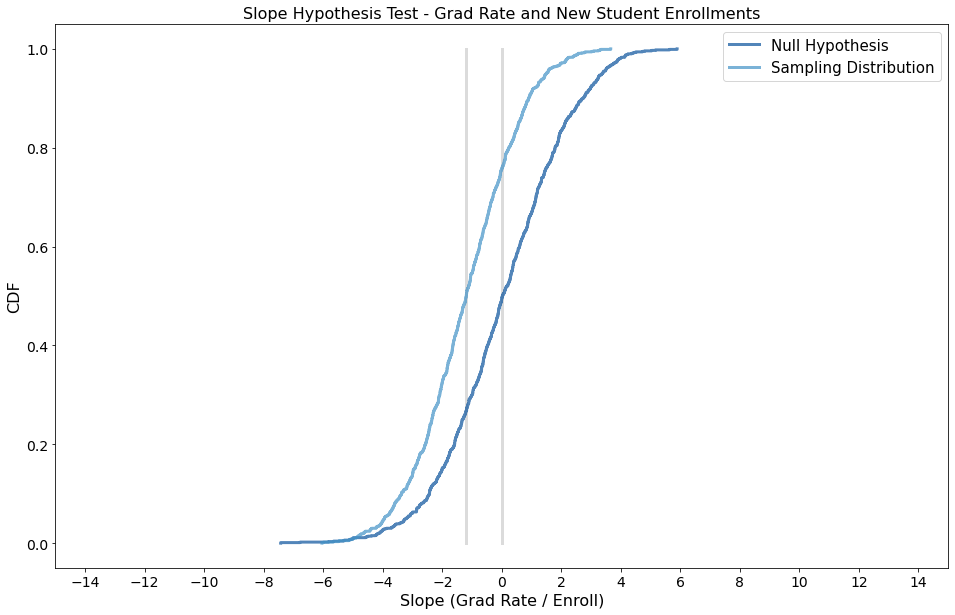

In [98]:
ht = SlopeTest((collegeData['Grad.Rate'], collegeData['Enroll']))
slopeP_Value = ht.PValue()

sampling_cdf = thinkstats2.Cdf(slopes)

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.rcParams['axes.titlesize'] = 16

thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')

ht.PlotCdf(label='Null Hypothesis')

thinkplot.set_font_size(5)

thinkplot.Cdf(sampling_cdf, label='Sampling Distribution')

thinkplot.Config(title='Slope Hypothesis Test - Grad Rate and New Student Enrollments', 
                 xlabel='Slope (Grad Rate / Enroll)',
                 ylabel='CDF',
                 xlim=[-15, 15],
                 legend=True, loc='upper left')

plt.xticks(np.arange(min([-14]), max([14]) + 1, 2.0))
plt.legend(prop={"size":15})

In [56]:
pvalue = sampling_cdf[0]
print('P-Value from sampling CDF: ' + str(round(pvalue, 5)))

P-Value from sampling CDF: 0.77522


From the above graph, we can see that the slopes have pretty much the same shape with the only difference being their means. Null Hypothesis is at 0 and the observed slope is at around -1. 

The P-value of the sampled slope (0.775) indicates that this is not at all statistically significant, which further lends credence to the Enroll variable not having a strong relationship the graduation rates of the universities.

<a id='Part_2-Multi_Regr'></a>
## Multiple Regression 
<a id='Part_2-All_Vars'></a>
### All Variables

Next, I did some multiple regression of my variables using Grad.Rate as the dependent variable.

In [53]:
formula = 'Q("Grad.Rate") ~ Private + Apps + Accept + Enroll + Q("Room.Board") + Books + Personal + PhD + Expend'

model = smf.ols(formula, data=collegeData)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Q("Grad.Rate")   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     45.66
Date:                Tue, 26 May 2020   Prob (F-statistic):           9.26e-66
Time:                        12:19:53   Log-Likelihood:                -3131.8
No. Observations:                 775   AIC:                             6284.
Df Residuals:                     765   BIC:                             6330.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          32.3928      3.559      9.101      0.000      25.406      39.380
Private[T.Yes]     12.7378      1.567      8.131      0.000       9.662      15.813
Apps                0.0020      0.000      4.502      0.000       0.001       0.003
Accept             -0.0019      0.001     -2.308      0.021      -0.004      -0.000
Enroll              0.0003      0.001      0.217      0.828      -0.003       0.003
Q("Room.Board")     0.0021      0.001      3.660      0.000       0.001       0.003
Books              -0.0025      0.003     -0.792      0.429      -0.009       0.004
Personal           -0.0039      0.001     -4.859      0.000      -0.005      -0.002
PhD                 0.2394      0.038      6.312      0.000       0.165       0.314
Expend              0.0001      0.000      1.126      0.261      -0.000       0.000
==============================================================================
Omnibus:                       11.029   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.062
Skew:                          -0.140   Prob(JB):                     0.000536
Kurtosis:                       3.623   Cond. No.                     9.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The above output is a model using of all my variables (from the entirety of my dataset) with Grad.Rate as the dependent variable. In order to make a better model I need to first take a look at which of my variables are statistically significant for trying to explain the dependent variable (Grad.Rate). 

To find which variables are significant, I am looking for p-values of 0.05 or less and I can find those values under the P>|t| column. From there I can see that the variables Enroll (0.828), Books (0.429), and Expend (0.261) all have p-values larger than 0.05 (thus not statistically significant to this model) and should be removed.

<a id='Part_2-Stat_Vars'></a>
### Only Statistically Significant Variables

Rerun the regression model with all variables that have p-value greater than 0.05 removed (Enroll, Books, and Expend).

In [52]:
formula = 'Q("Grad.Rate") ~ Private + Apps + Accept + Q("Room.Board") + Personal + PhD'

model = smf.ols(formula, data=collegeData)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Q("Grad.Rate")   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     68.28
Date:                Tue, 26 May 2020   Prob (F-statistic):           4.61e-68
Time:                        12:19:48   Log-Likelihood:                -3132.8
No. Observations:                 775   AIC:                             6280.
Df Residuals:                     768   BIC:                             6312.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          30.6998      3.203      9.585      0.000      24.412      36.988
Private[T.Yes]     13.1215      1.450      9.049      0.000      10.275      15.968
Apps                0.0021      0.000      5.298      0.000       0.001       0.003
Accept             -0.0021      0.001     -3.267      0.001      -0.003      -0.001
Q("Room.Board")     0.0022      0.001      3.998      0.000       0.001       0.003
Personal           -0.0040      0.001     -5.099      0.000      -0.006      -0.002
PhD                 0.2565      0.035      7.242      0.000       0.187       0.326
==============================================================================
Omnibus:                       11.366   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.094
Skew:                          -0.158   Prob(JB):                     0.000528
Kurtosis:                       3.607   Cond. No.                     4.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking under the P>|t| column again in the above output, I can see that there are no longer any variables in this model that have a p-value greater than 0.05 and thus they are statistically significant to explaining Grad.Rate.

<a id='Conclusion'></a>
# Conclusion

__Question:__ Does a University being Private or Public have an effect on its graduation rate and what factors specifically affect those rates?

__Hypothesis:__ Private universities might have a higher graduation rate than public universities and the biggest factors for the graduation rate will be: the number of students enrolled, the amount of faculty with PhD’s and economic factors of the university (Variables: Room.Board, Books, Personal and Expend).

From my restated question and hypothesis above, my conclusion based on this data and my analysis is that public universities actually have a higher graduation rate than private universities. 

Furthermore, the number of new student enrollments have a statistically insignificant effect on the grad rate and the variables that have significant effects are: the number of new student applications (Apps), number of new students accepted (Accept), cost of room and board (Room.Board), the amount of personal expenses for the student (Personal), and the percentage of faculty with PhD's (PhD). 

This also means that my hypothesis was only partially correct about the economic factors being the main variables that effect the grad rate, with the cost of books (Books) and expenditure (Expend) not having a significant effect.